In [1]:
# library used for loading the data and pre-processing

import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# library used for checking Trend, Seasonality, Cylic and Random variation

import statsmodels.api as ap

# libraries used for building models

from statsmodels.tsa.api import SimpleExpSmoothing as ses       # Simple/Single Exponential Smoothing
from statsmodels.tsa.api import Holt                            # Double Exponential Smoothing/ Holt's Linear Trend
from statsmodels.tsa.api import ExponentialSmoothing as exs     # Triple Exponential Smoothing/ Holt's Winter
import pmdarima as pm                                           #ARIMA Model

# library for checking Stationary in data

from statsmodels.tsa.stattools import adfuller

# library used for checking the evaluation metrics

from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
# Loading the data

data = pd.read_csv('TATAMOTORS.NS.csv')
data.shape

(7585, 7)

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1991-01-02,20.9596,21.857901,20.9596,21.857901,4.031160,0.0
1,1991-01-03,20.9596,21.857901,20.9596,21.857901,4.031160,0.0
2,1991-01-04,NaN,NaN,NaN,NaN,NaN,NaN
3,1991-01-07,20.3608,21.259001,20.0613,21.109301,3.893099,0.0
4,1991-01-08,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# for checking the min and max date

data['Date'].min(), data['Date'].max()

('1991-01-02', '2020-11-27')

In [5]:
# keeping the date and close price variable

data1 = data[['Date', 'Close']]
data1.head()

,Date,Close
0,1991-01-02,21.857901
1,1991-01-03,21.857901
2,1991-01-04,NaN
3,1991-01-07,21.109301
4,1991-01-08,NaN


In [6]:
# checking the null values

data1.isnull().sum()

Date       0
Close    375
dtype: int64

In [7]:
data1.shape

(7585, 2)

In [8]:
# Grouping the data by Date
# so that if two values are present for same date then the closing price is added

data2 = data1.groupby('Date')['Close'].sum()
data2.shape

(7585,)

## Now you can see that the shape remains as it is after grouping the data
## So there is no difference if you do not perform the above step

In [9]:
# Checking the dataype

data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7585 entries, 0 to 7584
Data columns (total 2 columns):
Date     7585 non-null object
Close    7210 non-null float64
dtypes: float64(1), object(1)
memory usage: 118.6+ KB


In [10]:
# Converting the date variable from object to date type

data1['Date'] = data1['Date'].astype('datetime64')
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7585 entries, 0 to 7584
Data columns (total 2 columns):
Date     7585 non-null datetime64[ns]
Close    7210 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 118.6 KB


In [11]:
# setting the date varibale as index column

data1.set_index('Date', inplace = True)
data1.head()

,Close
Date,
1991-01-02,21.857901
1991-01-03,21.857901
1991-01-04,NaN
1991-01-07,21.109301
1991-01-08,NaN


In [12]:
# resample the data on weekly basis taking average

a = data1['Close'].resample('W').mean()
a.shape

(1561,)

In [13]:
a.isnull().sum()

8

### As you can see still there is a null value in the data even after resampling the data on weekly basis
### To impute missing values we have to resample the data on monthly basis and check

In [14]:
# resample the data on Monthly basis taking average

b = data1['Close'].resample('M').mean()
b.shape

(359,)

In [15]:
b.isnull().sum()

0

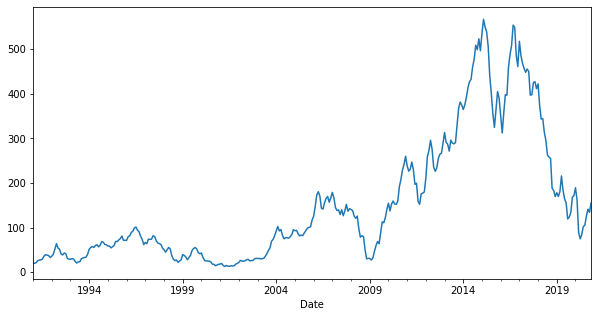

In [16]:
# Plotting the resample data

b.plot(figsize = (10,5))
plt.show()

# Train Test Split

In [17]:
# Training data from the year Jan 1991 - Dec 2012

train = b.loc[:'2012-12-31']
train.shape

(264,)

In [18]:
# Testing data from the year Jan 2013 - Nov 2020

test = b.loc['2013-01-31':]
test.shape

(95,)

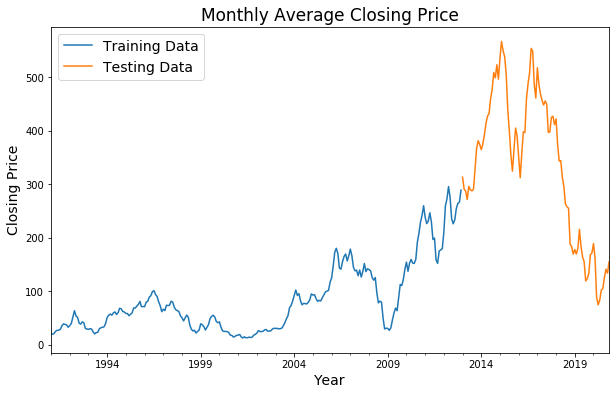

In [19]:
# Plotting the training and testing data

plt.figure(figsize = (10,6))
train.plot()
test.plot()

plt.title('Monthly Average Closing Price', fontsize = 17)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Closing Price', fontsize = 14)

plt.legend(['Training Data', 'Testing Data'], loc = 0, fontsize = 14)
plt.show()

## Decomposing the data into Trend and Seasonality

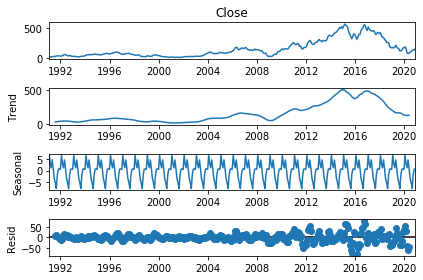

In [20]:
# 1st graph -> observed values
# 2nd graph -> trend component
# 3rd graph -> seasonality component
# 4th graph -> Residual

# if only trend then use double exponential / HOLT LINEAR TREND 
# trend and seasonality then use triple exponential / HOLT WINTER METHOD

dc = ap.tsa.seasonal_decompose(b)
dc.plot()
plt.show()                              

# Building Models and Evaluation

In [21]:
# Creating a dataframe to store the RMSE and AIC values of each Model

result = pd.DataFrame(columns = ['Algorithm','RMSE','AIC'])

result['Algorithm'] = ['Single Exponential', 'Double Exponential', 'Triple Exponential','ARIMA']

result.set_index('Algorithm', inplace = True)
 
result.head()

,RMSE,AIC
Algorithm,,
Single Exponential,NaN,NaN
Double Exponential,NaN,NaN
Triple Exponential,NaN,NaN
ARIMA,NaN,NaN


In [22]:
# Creating a dataframe to store the Predicted values of each Model

prediction = pd.DataFrame(columns = ['Actual Values'])
prediction['Actual Values'] = test.copy()

prediction.head()

,Actual Values
Date,
2013-01-31,313.300480
2013-02-28,291.184148
2013-03-31,286.966839
2013-04-30,271.574602
2013-05-31,296.148410


In [23]:
# user defined function to calculate RMSE, AIC value

def metric(model, actual_value, predicted_value):
    rmse = round(sqrt(mean_squared_error(actual_value, predicted_value)),4)
    aic = round(model.aic,4)
    return rmse,aic

## SIMPLE / SINGLE EXPONENTIAL SMOOTHING

In [24]:
# smoothing_level = alpha
# range is 0 to 1
# close to 0 -> older values are less important compared to recent values
# close to 1 -> older values are equally important

Simple_Exp = ses(train).fit(smoothing_level = 1)
prediction['Single'] = Simple_Exp.forecast(len(test))

In [25]:
rmse,aic = metric(Simple_Exp,prediction['Actual Values'],prediction['Single'])
print('RMSE :',rmse,'\nAIC :',aic)

result.loc['Single Exponential','RMSE'] = rmse
result.loc['Single Exponential','AIC'] = aic

RMSE : 144.5399 
AIC : 1248.901


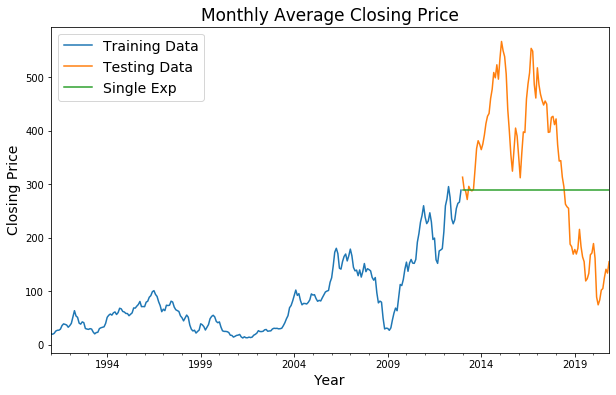

In [26]:
plt.figure(figsize = (10,6))
train.plot()
test.plot()
prediction['Single'].plot()

plt.title('Monthly Average Closing Price', fontsize = 17)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Closing Price', fontsize = 14)

plt.legend(['Training Data', 'Testing Data', 'Single Exp'], loc = 0, fontsize = 14)
plt.show()

## HOLT's TREND / DOUBLE EXPONENTIAL SMOOTHING

In [27]:
# smoothing_level = alpha
# range is 0 to 1
# close to 0 -> older values are less important compared to recent values
# close to 1 -> older values are equally important


# smoothing_slope -> beta
# Angle at which trend occurs
# range 0 to 1

Double_Exp = Holt(train).fit(smoothing_level = 1, smoothing_slope = 0.0001)
prediction['Double'] = Double_Exp.forecast(len(test))

In [28]:
rmse,aic = metric(Double_Exp,prediction['Actual Values'],prediction['Double'])
print('RMSE :',rmse,'\nAIC :',aic)

result.loc['Double Exponential','RMSE'] = rmse
result.loc['Double Exponential','AIC'] = aic

RMSE : 155.9942 
AIC : 1250.4582


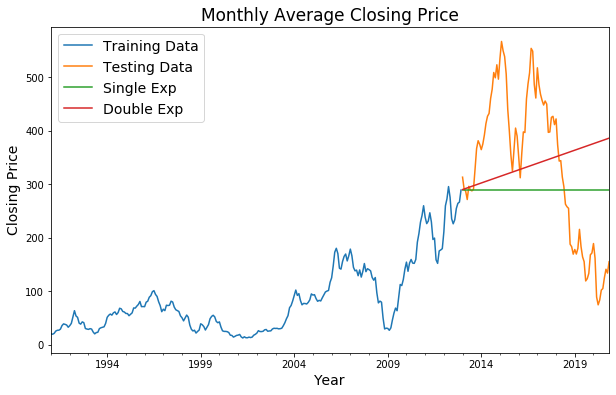

In [29]:
plt.figure(figsize = (10,6))
train.plot()
test.plot()
prediction['Single'].plot()
prediction['Double'].plot()

plt.title('Monthly Average Closing Price', fontsize = 17)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Closing Price', fontsize = 14)

plt.legend(['Training Data', 'Testing Data', 'Single Exp', 'Double Exp'], loc = 0, fontsize = 14)
plt.show()

## HOLT's WINTER / TRIPLE EXPONENTIAL SMOOTHING

In [30]:
# seasonal_periods = 12 -> 12 months the pattern is repeating
# trend = 'add' -> type of model to be build -> additive model
# trend = 'mul' -> type of model to be build -> multiplicative model

Triple_Exp = exs(train, trend = 'add', seasonal = 'mul', seasonal_periods = 12).fit()
prediction['Triple'] = Triple_Exp.forecast(len(test))

In [31]:
rmse,aic = metric(Triple_Exp,prediction['Actual Values'],prediction['Triple'])
print('RMSE :',rmse,'\nAIC :',aic)

result.loc['Triple Exponential','RMSE'] = rmse
result.loc['Triple Exponential','AIC'] = aic

RMSE : 172.6942 
AIC : 1212.3098


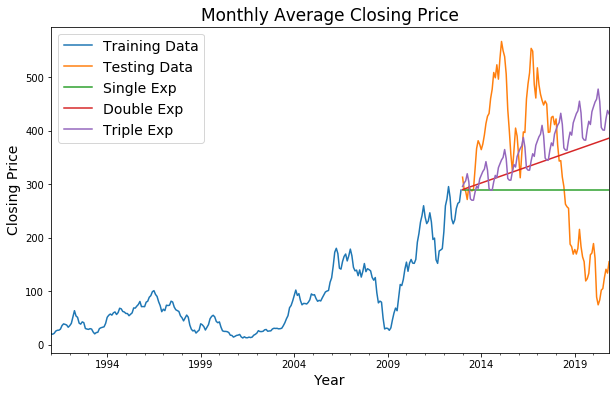

In [32]:
plt.figure(figsize = (10,6))
train.plot()
test.plot()
prediction['Single'].plot()
prediction['Double'].plot()
prediction['Triple'].plot()

plt.title('Monthly Average Closing Price', fontsize = 17)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Closing Price', fontsize = 14)

plt.legend(['Training Data', 'Testing Data', 'Single Exp', 'Double Exp', 'Triple Exp'], loc = 0, fontsize = 14)
plt.show()

### Checking for Stationarity of data
### H0 : Data is non-stationary <- Null Hypothesis
### H1 : Data is stationary <- Alternate Hypothesis

In [33]:
ad = adfuller(b)
print('P-value :',ad[1])

P-value : 0.5894616548206688


#### Since P-value is greater than 5% we reject the Null Hypothesis
#### So the data is stationary

# ARIMA MODEL

In [34]:
# b -> data

# start_p -> starting p value
# max_p -> maximum p value

# d = None -> no differencing
# max_d = 2 -> if required then upto 2nd order differencing

# start_q -> starting q value
# max_q -> maximum q value

# similar for P,D,Q

# max_order = 10 -> to set restriction
# sumation of p,q and P,Q should be less then equal to 10
# p+q + P+Q <= 10 
# p+q <= 3

# seasonality m = 12 -> yearly pattern
# seasonal = True -> use SARIMA

# information_criterion = 'aic' -> model evaluation parameter

# test = adf -> if data is non stationary

# trace = True -> for displaying all combinations 

In [35]:
model_arima = pm.auto_arima(b, start_p = 0, max_p = 3, 
                      d = None, max_d = 2,
                      start_q = 0, max_q = 3,
                      start_P = 0, max_P = 3, 
                      D = None, max_D = 1, 
                      start_Q = 0, max_Q = 3,
                      max_order = 15,
                      m = 12, seasonal = True,
                      information_criterion = 'aic',
                      stepwise = False,
                      suppress_warnings = True,
                      test = 'adf',
                      trace = True,
                      random_state = 10)

Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=True]; AIC=3060.252, BIC=3068.013, Time=0.457 seconds
Fit ARIMA(0,1,0)x(0,0,1,12) [intercept=True]; AIC=3055.661, BIC=3067.302, Time=0.746 seconds
Fit ARIMA(0,1,0)x(0,0,2,12) [intercept=True]; AIC=3048.298, BIC=3063.820, Time=1.717 seconds
Fit ARIMA(0,1,0)x(0,0,3,12) [intercept=True]; AIC=3047.391, BIC=3066.794, Time=5.180 seconds
Fit ARIMA(0,1,0)x(1,0,0,12) [intercept=True]; AIC=3053.709, BIC=3065.351, Time=1.244 seconds
Fit ARIMA(0,1,0)x(1,0,1,12) [intercept=True]; AIC=3052.309, BIC=3067.832, Time=0.994 seconds
Fit ARIMA(0,1,0)x(1,0,2,12) [intercept=True]; AIC=3046.556, BIC=3065.959, Time=3.139 seconds
Fit ARIMA(0,1,0)x(1,0,3,12) [intercept=True]; AIC=3048.541, BIC=3071.824, Time=7.934 seconds
Fit ARIMA(0,1,0)x(2,0,0,12) [intercept=True]; AIC=3049.848, BIC=3065.370, Time=1.469 seconds
Fit ARIMA(0,1,0)x(2,0,1,12) [intercept=True]; AIC=3047.377, BIC=3066.780, Time=2.649 seconds
Fit ARIMA(0,1,0)x(2,0,2,12) [intercept=True]; AIC=3048.536, BIC=3071.8

Fit ARIMA(1,1,1)x(2,0,0,12) [intercept=True]; AIC=3022.451, BIC=3045.735, Time=3.511 seconds
Fit ARIMA(1,1,1)x(2,0,1,12) [intercept=True]; AIC=3019.892, BIC=3047.056, Time=4.176 seconds
Fit ARIMA(1,1,1)x(2,0,2,12) [intercept=True]; AIC=3021.522, BIC=3052.566, Time=7.326 seconds
Fit ARIMA(1,1,1)x(2,0,3,12) [intercept=True]; AIC=3022.659, BIC=3057.584, Time=19.533 seconds
Fit ARIMA(1,1,1)x(3,0,0,12) [intercept=True]; AIC=3021.747, BIC=3048.911, Time=6.831 seconds
Fit ARIMA(1,1,1)x(3,0,1,12) [intercept=True]; AIC=3021.740, BIC=3052.785, Time=14.068 seconds
Fit ARIMA(1,1,1)x(3,0,2,12) [intercept=True]; AIC=3023.468, BIC=3058.393, Time=19.514 seconds
Fit ARIMA(1,1,1)x(3,0,3,12) [intercept=True]; AIC=3024.384, BIC=3063.189, Time=23.559 seconds
Fit ARIMA(1,1,2)x(0,0,0,12) [intercept=True]; AIC=3029.389, BIC=3048.791, Time=0.502 seconds
Fit ARIMA(1,1,2)x(0,0,1,12) [intercept=True]; AIC=3030.447, BIC=3053.730, Time=1.301 seconds
Fit ARIMA(1,1,2)x(0,0,2,12) [intercept=True]; AIC=3023.421, BIC=30

Fit ARIMA(2,1,3)x(0,0,0,12) [intercept=True]; AIC=3027.957, BIC=3055.121, Time=2.911 seconds
Fit ARIMA(2,1,3)x(0,0,1,12) [intercept=True]; AIC=3029.979, BIC=3061.023, Time=6.623 seconds
Fit ARIMA(2,1,3)x(0,0,2,12) [intercept=True]; AIC=3024.585, BIC=3059.510, Time=8.408 seconds
Fit ARIMA(2,1,3)x(0,0,3,12) [intercept=True]; AIC=3024.375, BIC=3063.180, Time=19.356 seconds
Fit ARIMA(2,1,3)x(1,0,0,12) [intercept=True]; AIC=3031.988, BIC=3063.032, Time=6.158 seconds
Fit ARIMA(2,1,3)x(1,0,1,12) [intercept=True]; AIC=3030.216, BIC=3065.141, Time=6.360 seconds
Fit ARIMA(2,1,3)x(1,0,2,12) [intercept=True]; AIC=3021.620, BIC=3060.425, Time=11.872 seconds
Fit ARIMA(2,1,3)x(1,0,3,12) [intercept=True]; AIC=3023.474, BIC=3066.160, Time=26.206 seconds
Fit ARIMA(2,1,3)x(2,0,0,12) [intercept=True]; AIC=3015.447, BIC=3050.371, Time=11.135 seconds
Fit ARIMA(2,1,3)x(2,0,1,12) [intercept=True]; AIC=3021.353, BIC=3060.158, Time=11.184 seconds
Fit ARIMA(2,1,3)x(2,0,2,12) [intercept=True]; AIC=3023.320, BIC=3

In [36]:
# Summary of the ARIMA Model

model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  359
Model:             SARIMAX(3, 1, 3)x(0, 0, 3, 12)   Log Likelihood               -1495.412
Date:                            Wed, 02 Dec 2020   AIC                           3012.825
Time:                                    17:22:46   BIC                           3055.511
Sample:                                         0   HQIC                          3029.801
                                            - 359                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2659      1.128      0.236      0.814      -1.945       2.476
ar.L1          0.9155      0.099      9.222      0.000       0.721       1.110
ar.L2         -0.3471      0.139     -2.502      0.012      -0.619      -0.075
ar.L3         -0.4375      0.096     -4.552      0.000      -0.626      -0.249
ma.L1         -0.6440      0.085     -7.596      0.000      -0.810      -0.478
ma.L2          0.0525      0.108      0.486      0.627      -0.159       0.264
ma.L3          0.6852      0.078      8.826      0.000       0.533       0.837
ma.S.L12      -0.0600      0.040     -1.500      0.134      -0.138       0.018
ma.S.L24       0.1483      0.043      3.442      0.001       0.064       0.233
ma.S.L36       0.1135      0.048      2.356      0.018       0.019       0.208
sigma2       245.0103     13.531     18.108      0.000     218.491     271.530
===================================================================================
Ljung-Box (Q):                       55.77   Jarque-Bera (JB):               102.64
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):              19.37   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
# Best Values Choosen 

model_arima

ARIMA(order=(3, 1, 3), seasonal_order=(0, 0, 3, 12), suppress_warnings=True)

In [38]:
# Building the SARIMAX Model

from statsmodels.tsa.statespace.sarimax import SARIMAX as sa

model_sarimax = sa(b, order = (3,1,3), seasonal_order = (0,0,3,12)).fit(maxiter = 200)

In [39]:
pred = model_sarimax.get_prediction(start = pd.to_datetime('2013-01-31'))
prediction['ARIMA'] = pred.predicted_mean

In [40]:
rmse,aic = metric(model_sarimax,prediction['Actual Values'],prediction['ARIMA'])
print('RMSE :',rmse,'\nAIC :',aic)

result.loc['ARIMA','RMSE'] = rmse
result.loc['ARIMA','AIC'] = aic

RMSE : 25.5707 
AIC : 3010.3329


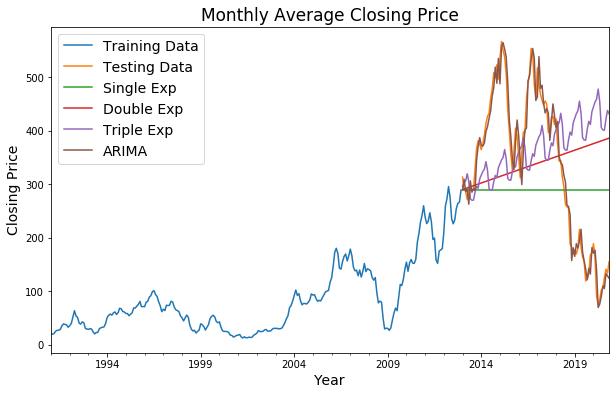

In [41]:
plt.figure(figsize = (10,6))
train.plot()
test.plot()
prediction['Single'].plot()
prediction['Double'].plot()
prediction['Triple'].plot()
prediction['ARIMA'].plot()

plt.title('Monthly Average Closing Price', fontsize = 17)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Closing Price', fontsize = 14)

plt.legend(['Training Data', 'Testing Data', 'Single Exp', 'Double Exp', 'Triple Exp', 'ARIMA'], loc = 0, fontsize = 14)
plt.show()

## FORECAST

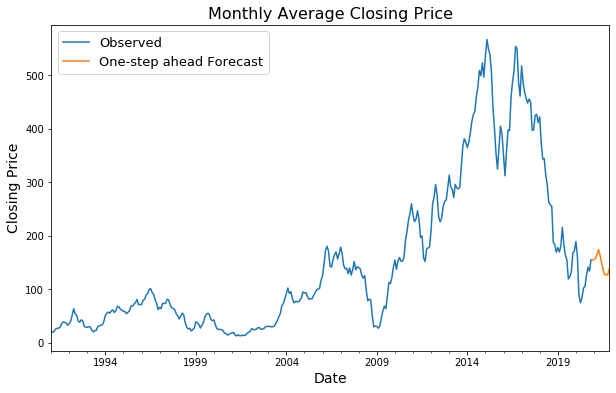

In [42]:
pred_uc = model_sarimax.get_forecast(steps = 12)
plt.figure(figsize = (10,6))
ax = b.plot()
pred_uc.predicted_mean.plot(ax = ax)

plt.title('Monthly Average Closing Price', fontsize = 16)
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylabel('Closing Price', fontsize = 14)

plt.legend(['Observed','One-step ahead Forecast'], fontsize = 13)
plt.show()

In [43]:
pred_uc.predicted_mean

2020-12-31    154.688873
2021-01-31    155.461147
2021-02-28    158.059134
2021-03-31    165.334441
2021-04-30    174.226128
2021-05-31    163.872219
2021-06-30    149.974782
2021-07-31    136.792845
2021-08-31    127.070162
2021-09-30    127.984952
2021-10-31    126.537607
2021-11-30    137.773792
Freq: M, dtype: float64

### MODEL WISE EVALUATION

In [44]:
result.head()

,RMSE,AIC
Algorithm,,
Single Exponential,144.54,1248.9
Double Exponential,155.994,1250.46
Triple Exponential,172.694,1212.31
ARIMA,25.5707,3010.33


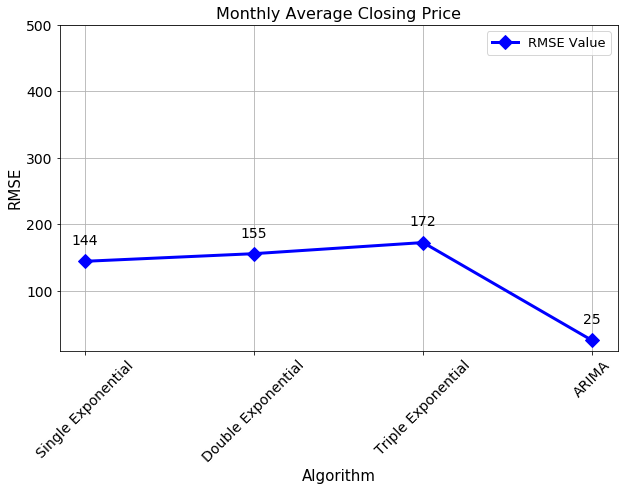

In [63]:
plt.figure(figsize = (10,6))
plt.plot(result.index, result['RMSE'].values, '-bD', markersize = 10, linewidth = 3)
plt.title('Monthly Average Closing Price', fontsize = 16)
plt.xlabel('Algorithm', fontsize = 15)
plt.ylabel('RMSE', fontsize = 15)

plt.legend(['RMSE Value'], fontsize = 13)
plt.xticks(rotation = 45, fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim(10,500)


for i, v in enumerate(result['RMSE']):
    plt.text(i, v+25, "%d" %v, ha = 'center', fontsize = 14)

plt.grid()
plt.show()

## MODEL WISE PREDICTION

In [46]:
prediction.head()

,Actual Values,Single,Double,Triple,ARIMA
Date,,,,,
2013-01-31,313.300480,289.1635,290.185100,295.824411,289.646489
2013-02-28,291.184148,289.1635,291.206701,302.296326,309.426264
2013-03-31,286.966839,289.1635,292.228302,306.537039,286.351603
2013-04-30,271.574602,289.1635,293.249903,319.719953,290.712868
2013-05-31,296.148410,289.1635,294.271504,304.893900,262.804407
